# 구글 드라이브 마운트

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 살펴보기

In [11]:
import string

# 특수 문자들이 미리 static하게 저장되어 있음, punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
# from glob import glob

source = "/content/drive/MyDrive/ml-class-rhseung/data/kor_eng.txt"

source

'/content/drive/MyDrive/ml-class-rhseung/data/kor_eng.txt'

In [12]:
with open(source, 'r', encoding='utf-8') as f:
    content = f.readlines()

content[:5]

['Go.\t가.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8363271 (Eunhee)\n',
 'Hi.\t안녕.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee)\n',
 'Run!\t뛰어!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8355891 (Eunhee)\n',
 'Run.\t뛰어.\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #8363273 (Eunhee)\n',
 'Who?\t누구?\tCC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #6820074 (yesjustryan)\n']

In [13]:
from typing import List, Tuple

eng_to_kor: List[Tuple[str, str]] = []      # [(eng1, kor1), (eng2, kor2), ...] 구조로 이루어진 번역 쌍 리스트

with open(source, 'r', encoding='utf-8') as f:
    for line in f:
        eng, kor = line.split('\t')[:2]

        def clear(s):
            # 전부 소문자로 바꾸고 특수 문자 제거
            return s.lower().strip(string.punctuation)

        eng_to_kor.append((clear(eng), clear(kor)))

In [14]:
len(eng_to_kor)

5870

In [15]:
eng_to_kor[:5]

[('go', '가'), ('hi', '안녕'), ('run', '뛰어'), ('run', '뛰어'), ('who', '누구')]

In [16]:
eng_to_kor[1000:1005]

[("i'm heartbroken", '제 마음이 아파요'),
 ("i'm just sleepy", '나 졸려'),
 ("i'm not sulking", '나 삐친 거 아니야'),
 ("i'm on the list", '나는 명단에 있다'),
 ('is tom with you', '톰이랑 같이 있어')]

# 학습용 데이터 만들기

In [17]:
# BOW = Bag Of Words, 단어를 특정 수로 치환하는 것

SOS = 0     # Start Of Sentence
EOS = 1     # End Of Sentence

def get_BOW(sentences):
    BOW = {"<SOS>": SOS, "<EOS>": EOS}

    for sentence in sentences:
        for word in sentence.split():
            if word not in BOW:
                BOW[word] = len(BOW)

    return BOW

In [18]:
import torch
import numpy as np
from torch.utils.data import Dataset

class Eng2Kor(Dataset):
    def __init__(self, path, max_length, device='cpu'):
        self.device = device

        self.eng_sentences = []
        self.kor_sentences = []
        self.max_length = max_length

        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                eng, kor = line.split('\t')[:2]

                # 전부 소문자로 바꾸고 특수 문자 제거
                clear = lambda s: s.lower().strip(string.punctuation)

                eng, kor = clear(eng), clear(kor)

                # 단어 수가 너무 많아지면 메모리 사용량이 너무 커져서 문장의 단어 길이를 제한함
                if len(eng.split()) <= self.max_length and len(kor.split()) <= self.max_length:
                    self.eng_sentences.append(eng)
                    self.kor_sentences.append(kor)

        self.eng_BOW = get_BOW(self.eng_sentences)
        self.kor_BOW = get_BOW(self.kor_sentences)

    def gen_seq(self, sentence):    # 문장 끝에 EOS 토큰 붙여주기
        return sentence.split() + ['<EOS>']

    def __len__(self):
        return len(self.eng_sentences)

    def __getitem__(self, idx: int):    # BOW 객체의 값으로 변환된 문장 벡터(텐서) 반환
        x = np.array([self.eng_BOW[e] for e in self.gen_seq(self.eng_sentences[idx])])
        y = np.array([self.kor_BOW[e] for e in self.gen_seq(self.kor_sentences[idx])])

        x = torch.tensor(x, dtype=torch.long).to(self.device)
        y = torch.tensor(y, dtype=torch.long).to(self.device)

        return x, y

# 인코더 정의하기

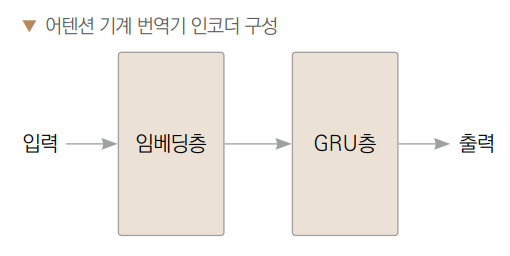

In [19]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()

        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim)

    def forward(self, x, h):
        # print(f'{x.shape=}, {h.shape=}')

        x = self.embedding(x)

        # print(f'{x.shape=}, {h.shape=}')

        x = x.reshape(1, 1, -1)

        # print(f'{x.shape=}, {h.shape=}')

        output, h_next = self.gru(x, h)

        # print(f'{output.shape=}, {h_next.shape=}')

        return output, h_next

# 디코더 정의하기

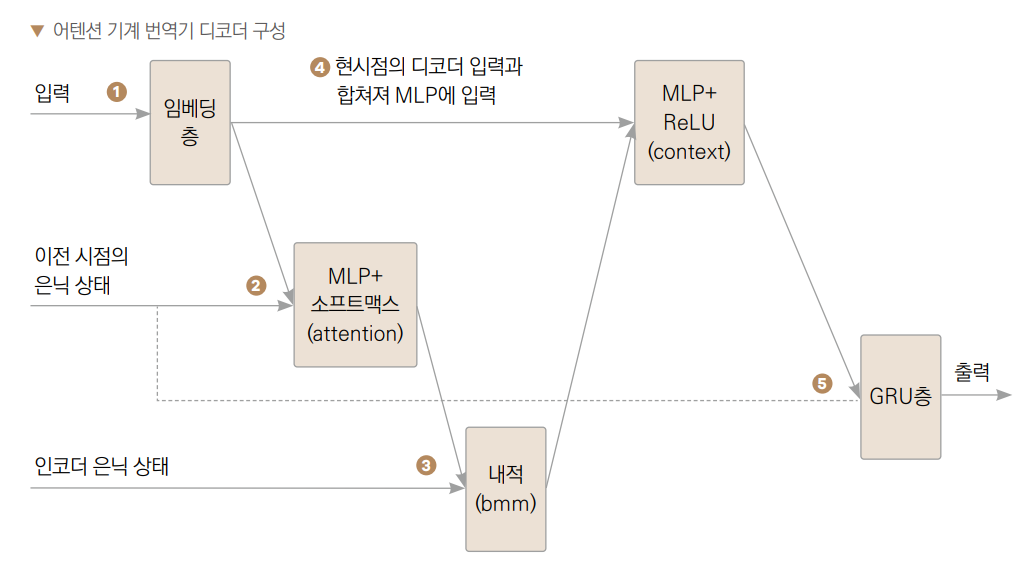

In [20]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, max_length):
        super(Decoder, self).__init__()

        self.max_length = max_length + 1    # <EOS> 토큰 고려해서 +1

        self.embedding = nn.Embedding(num_embeddings=output_dim, embedding_dim=hidden_dim)
        self.attention = nn.Linear(hidden_dim*2, self.max_length)
        self.feature_extract = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout = nn.Dropout(p=0.1)
        self.gru = nn.GRU(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h, encoder_outputs):
        # print(f'{x.shape=}, {h.shape=}')

        x = self.embedding(x)

        # print(f'{x.shape=}, {h.shape=}')

        x = x.reshape(1, 1, -1)

        # print(f'{x.shape=}, {h.shape=}')

        x = self.dropout(x)

        # print(f'{x.shape=}, {h.shape=}')

        concat = torch.cat((x[0], h[0]), dim=-1)

        # print(f'{concat.shape=}')

        attentioned = self.attention(concat)

        # print(f'{attentioned.shape=}')

        attention_weights = self.softmax(attentioned)

        # print(f'{attention_weights.shape=}')

        attention_applied = (attention_weights @ encoder_outputs).unsqueeze(0)  # torch.bmm() 으로도 가능

        # print(f'{attention_applied.shape=}')

        output = torch.cat((x[0], attention_applied[0]), dim=1)

        # print(f'{output.shape=}')

        output = self.feature_extract(output).unsqueeze(0)

        # print(f'{output.shape=}')

        output = self.relu(output)

        # print(f'{output.shape=}')

        output, h_next = self.gru(output, h)

        # print(f'{output.shape=}, {h_next.shape=}')

        output = self.out(output[0])

        # print(f'{output.shape=}')

        return output

# 어텐션 기계 번역기 학습하기

In [21]:
# from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = Eng2Kor(path=source, max_length=10, device=device)

def dataloader(dset):   # 사실 이렇게 할거면 그냥 dset를 iterate하면 되나 pytorch 관례에 의해 loader-like 객체를 따로 만들고 iterate함
    yield from dset

In [22]:
input_dim = len(dataset.eng_BOW)
hidden_dim = 64
output_dim = len(dataset.kor_BOW)

encoder = Encoder(input_dim, hidden_dim).to(device)
decoder = Decoder(hidden_dim, output_dim, dataset.max_length).to(device)

In [23]:
import torch.optim as optim

encoder_optim = optim.Adam(encoder.parameters(), lr=1e-4)
decoder_optim = optim.Adam(decoder.parameters(), lr=1e-4)
cost = nn.CrossEntropyLoss().to(device)

In [24]:
from tqdm import tqdm
from random import random

for epoch in range(100):
    total_loss = 0      # 에폭 당 loss

    with tqdm(dataloader(dataset), total=len(dataset)) as loader:
        loader.set_description(f'Epoch {epoch+1}')

        for x, y in loader:
            # 초기 은닉 상태와 인코더 출력값 저장할 텐서 선언
            encoder_h = torch.zeros(1, 1, hidden_dim).to(device)
            encoder_outputs = torch.zeros(decoder.max_length, hidden_dim).to(device)

            encoder_optim.zero_grad()
            decoder_optim.zero_grad()

            for i in range(len(x)): # 각 영어 단어에 대해
                encoder_output, encoder_h = encoder(x[i], encoder_h)
                encoder_outputs[i] = encoder_output[0, 0]   # encoder_output shape: (1, 1, 64)

            # 초기 디코더 입력과 은닉 상태(인코더의 마지막 시점의 은닉 상태)
            decoder_input = torch.tensor([[SOS]]).to(device)
            decoder_h = encoder_h

            # teacher forcing 사용 가챠 굴리기
            use_teacher_forcing = random() < 0.5
            loss = 0

            for i in range(len(y)): # 각 정답 영어 단어에 대해
                decoder_output = decoder(decoder_input, decoder_h, encoder_outputs)     # shape: self.out((1, 1, 64)[0]) -> linear (1, 64) to (1, output_dim) -> (1, 7516)

                if not use_teacher_forcing:     # teacher forcing 안 할거면 디코더 출력 중 최댓값을 다시 디코더의 인풋으로
                    maxidx = decoder_output.argmax()
                    decoder_input = maxidx.detach()

                target = y[i].unsqueeze(0)
                loss += cost(decoder_output, target)

                if not use_teacher_forcing:
                    if decoder_input.item() == EOS:   # <EOS> 오면 문장 끝
                        break
                else:
                    decoder_input = target  # teacher forcing 할거면 정답을 디코더의 인풋으로

            loss.backward()
            encoder_optim.step()
            decoder_optim.step()

            total_loss += loss.item() / len(dataset)

            loader.set_postfix(loss=total_loss)

Epoch 100: 100%|██████████| 5684/5684 [01:40<00:00, 56.56it/s, loss=11]


In [25]:
# torch.save(encoder.state_dict(), "/content/drive/MyDrive/ml-class-rhseung/numpy/attention_encoder.pth")
# torch.save(decoder.state_dict(), "/content/drive/MyDrive/ml-class-rhseung/numpy/attention_decoder.pth")

# 모델 성능 평가하기

In [50]:
from random import randint

encoder.load_state_dict(torch.load("/content/drive/MyDrive/ml-class-rhseung/numpy/attention_encoder.pth", map_location=device))
decoder.load_state_dict(torch.load("/content/drive/MyDrive/ml-class-rhseung/numpy/attention_decoder.pth", map_location=device))

idx = randint(0, len(dataset))  # 아무 문장 고르기
x_sentence = dataset.eng_sentences[idx]
y_sentence = dataset.kor_sentences[idx]

x, y = dataset[idx]

In [51]:
x_sentence, y_sentence

('tom is ashamed of his body', '톰은 자기 몸을 창피해해')

In [52]:
x, y    # BOW로 바꾼 문장 벡터

(tensor([  61,  228, 1891,  167,  727, 1892,    1], device='cuda:0'),
 tensor([ 161, 3601, 3869, 3870,    1], device='cuda:0'))

In [53]:
encoder_h = torch.zeros(1, 1, hidden_dim).to(device)
encoder_outputs = torch.zeros(decoder.max_length, hidden_dim).to(device)

# 영어 문장을 단어 단위로 인코더에 모두 넣기
for i in range(len(x)):
    encoder_output, encoder_h = encoder(x[i], encoder_h)
    encoder_outputs[i] = encoder_output[0, 0]

In [54]:
encoder_output.shape, encoder_h.shape

(torch.Size([1, 1, 64]), torch.Size([1, 1, 64]))

In [55]:
decoder_input = torch.tensor([[SOS]]).to(device)
decoder_h = encoder_h
pred_sentence = ""

# 디코더로 한국어 문장 생성
for i in range(decoder.max_length):
    decoder_output = decoder(decoder_input, decoder_h, encoder_outputs)

    # .topk(k: int) 함수는 텐서에서 k번째로 큰 값의 (값, 인덱스)를 반환. 배치 사이즈 차원까지 그대로 모양 유지해서 줌
    _, maxidx = decoder_output.topk(1)
    decoder_input = maxidx

    print(maxidx, list(dataset.kor_BOW.keys())[decoder_input.item()])

    if decoder_input.item() == EOS:
        break

    pred_sentence += list(dataset.kor_BOW.keys())[decoder_input.item()] + " "

tensor([[161]], device='cuda:0') 톰은
tensor([[3601]], device='cuda:0') 자기
tensor([[3869]], device='cuda:0') 몸을
tensor([[1]], device='cuda:0') <EOS>


In [56]:
pred_sentence = pred_sentence.strip()

In [57]:
print(f'x    = "{x_sentence}"')
print(f'pred = "{pred_sentence}"')
print(f'y    = "{y_sentence}"')

x    = "tom is ashamed of his body"
pred = "톰은 자기 몸을"
y    = "톰은 자기 몸을 창피해해"
